In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# The prysm stuff
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import Wavefront, focus_fixed_sampling
from prysm.geometry import circle,spider
from prysm.segmented import CompositeHexagonalAperture
from prysm import thinlens
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_sequence,
    hopkins,
    sum_of_2d_modes
)

np.random.seed(20240820)

In [2]:
pth = '/Users/work/Desktop/orkid_coma/'
psf0 = []
psf2 = []

for i in range(4):
    psf0.append(fits.getdata(pth+f'0/pd_test_0020_000{i}.fits').astype(np.float64))
    psf2.append(fits.getdata(pth+f'2/pd_test_0021_000{i}.fits').astype(np.float64))

In [3]:
# Crop and center
center = [100, 65]
crop = 60

cropped_psf0 = []
cropped_psf2 = []

# Crop data
for p0, p2 in zip(psf0, psf2):
    _psf = p0[0,center[0]-crop:center[0]+crop, center[1]-crop:center[1]+crop]
    _psf[np.isnan(_psf)] = 1e-20
    _psf -= np.median(_psf[0:-5])
    _psf[_psf < 1e-20] = 1e-20
    cropped_psf0.append(_psf)

    _psf = p2[0,center[0]-crop:center[0]+crop, center[1]-crop:center[1]+crop]
    _psf[np.isnan(_psf)] = 1e-20
    _psf -= np.median(_psf[0:-5])
    _psf[_psf < 1e-20] = 1e-20
    cropped_psf2.append(_psf)

# take median
med_psf0 = np.median(cropped_psf0, axis=0)
med_psf2 = np.median(cropped_psf2, axis=0)

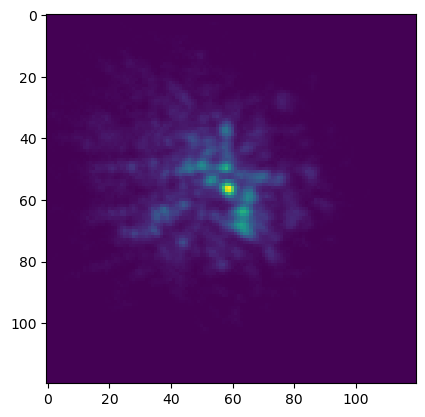

In [4]:
plt.imshow(_psf)

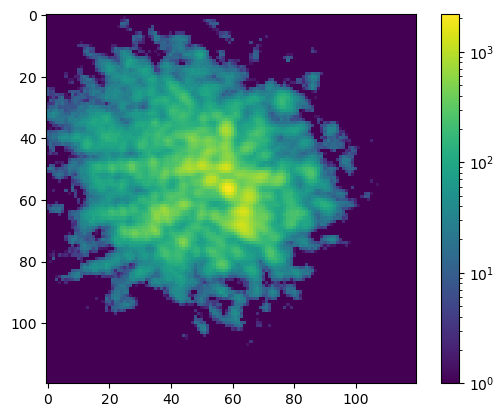

In [5]:
from matplotlib.colors import LogNorm
plt.imshow(med_psf2, norm=LogNorm(vmin=1e0))
plt.colorbar()
plt.show()

energy_in_psf0 = med_psf0.sum()
energy_in_psf2 = med_psf2.sum()

In [6]:
# USER INPUT HERE
# IC = Instrument Configuration
epd = 10950
IC = {
    'image_dx' : 12.2, # um
    'pupil_diameter' : epd, # mm
    'focal_length' : 34.3 * epd, # mm
    'wavelength' : 0.94, # um
}
SEGMENTED_PUPIL = False

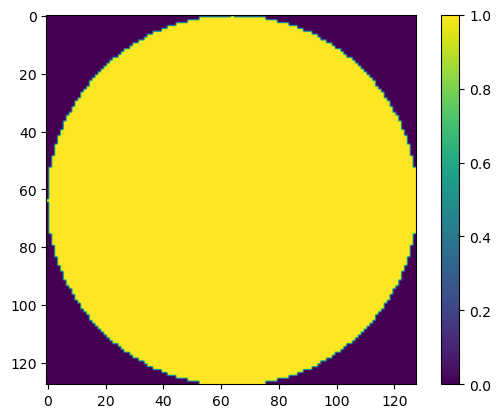

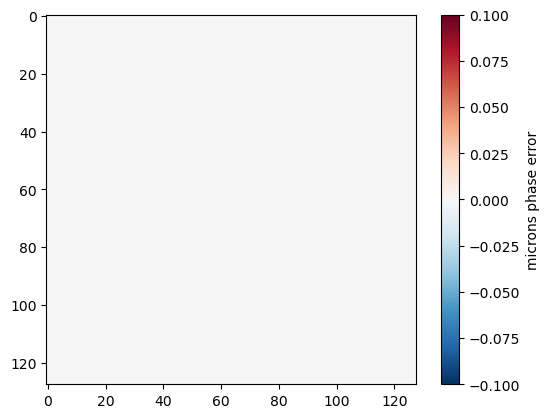

In [7]:
# optical system parameters
epd = IC['pupil_diameter'] # mm
efl = IC['focal_length'] # mm, Keck is F/13 I think
fno = efl / epd
wvl = IC['wavelength'] # um

# build the coordinate grids
x, y = make_xy_grid(128, diameter=epd)
r, t = cart_to_polar(x, y)
dx_p = x[0,1] - x[0,0]

if SEGMENTED_PUPIL:
    # make a keck-like pupil
    cha = CompositeHexagonalAperture(x, y, 3, 1.32e3, 0.007e3, exclude=(0,))

    # set up spiders
    m1 = spider(1, .1e3, x, y, rotation=-120)
    m2 = spider(1, .1e3, x, y, rotation=-60)
    m3 = spider(1, .1e3, x, y, rotation=90)
    spider_ = m1&m2&m3
    A = cha.amp & spider_

else:
    A = circle(epd / 2, r)

plt.figure()
plt.imshow(A)
plt.colorbar()
plt.show()

# construct a polynomial basis to generate wavefront error
r_z = r / (epd / 2) # normalized radius
nms = [noll_to_nm(j) for j in range(2, 1500)]
coefs = np.random.random(len(nms))
basis = list(zernike_nm_sequence(nms, r, t, norm=True))
basis_norm = [b / np.max(np.abs(b)) for b in basis]
phs = sum_of_2d_modes(basis_norm, coefs) * 0/5
amp = A

plt.figure()
plt.imshow(phs * amp, cmap='RdBu_r')
plt.colorbar(label='microns phase error')
plt.show()

# Propagate to focus
# NOTE: Phase should be in nm, wvl should be in microns, dx_p should be in mm
# NOTE: WAVEFRONT AND FOCUS_FIXED_SAMPLING HAVE DIFFERENT NORMALIZATIONS AND THROW OFF THE ALGORITHM
k = 2 * np.pi / wvl # enforces phs in microns
wf = amp * np.exp(1j * k * phs)

def prop_to_focus(wavefunction, defocus_waves=0):

    # configure the defocus polynomial
    focus_polynomial = hopkins(0, 2, 0, r_z, t, 0) * defocus_waves
    defocus_aberration = amp * np.exp(-1j * 2 * np.pi * focus_polynomial)


    psf = focus_fixed_sampling(wavefunction=wavefunction * defocus_aberration,
                            input_dx=dx_p,
                            prop_dist=efl,
                            wavelength=wvl,
                            output_dx=IC['image_dx'],
                            output_samples=200)
    psf0 = np.abs(psf)**2
    return psf0

psf0 = prop_to_focus(wf, defocus_waves=0)
psf1 = prop_to_focus(wf, defocus_waves=thinlens.image_displacement_to_defocus(1, fno))
psf2 = prop_to_focus(wf, defocus_waves=thinlens.image_displacement_to_defocus(2, fno))
# psf3 = prop_to_focus(wf, defocus_waves=3)

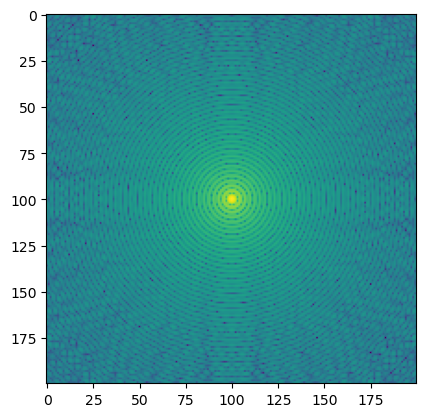

In [13]:
plt.imshow(np.log10(psf0))

In [8]:
# configure the individual optimizers
import poi
energy_scale0 = psf0.sum() / energy_in_psf0
energy_scale2 = psf2.sum() / energy_in_psf2
adpr0 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, med_psf0 * energy_scale0 , IC['image_dx'], defocus_waves=thinlens.image_displacement_to_defocus(0, fno))
# adpr0.set_optimization_method(zonal=True)
adpr1 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, med_psf2 * energy_scale2, IC['image_dx'], defocus_waves=thinlens.image_displacement_to_defocus(2, fno))
# adpr1.set_optimization_method(zonal=True)

# set up the net optimizer
optlist = [adpr0, adpr1]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

In [9]:
from scipy.optimize import minimize
from prysm.x.optym.optimizers import F77LBFGSB, Adam
# results = minimize(fdpr.fg,
#                    x0=np.zeros(len(coefs)),
#                    jac=True, method='BFGS',
#                    options={'maxls': 20, 'ftol': 1e-17, 'gtol': 1e-17, 'disp': 1, 'maxiter': 1000})

# set up optimizer
opt = F77LBFGSB(fdpr.fg, x0=np.random.random(len(basis)), memory=15)

for _ in range(10000):
    x, f, g = opt.step()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1498     M =           15

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  1.62442D+06    |proj g|=  2.33978D+06

At iterate    1    f=  1.04181D+06    |proj g|=  1.72963D+06

At iterate    2    f=  3.98970D+05    |proj g|=  6.18646D+05

At iterate    3    f=  2.48103D+05    |proj g|=  3.54729D+05

At iterate    4    f=  1.29610D+05    |proj g|=  1.12895D+05

At iterate    5    f=  8.60186D+04    |proj g|=  4.00644D+04

At iterate    6    f=  6.54978D+04    |proj g|=  1.65412D+04

At iterate    7    f=  6.19369D+04    |proj g|=  1.69301D+04

At iterate    8    f=  5.75507D+04    |proj g|=  1.05985D+04

At iterate    9    f=  5.40133D+04    |proj g|=  1.11706D+04

At iterate   10    f=  5.18618D+04    |proj g|=  5.81040D+03

At iterate   11    f=  5.06213D+04    |proj g|=  5.03747D+03

At iterate   12    f=  4.92206D+04    |proj g|=  3.83316D+03

At iterate   13    f=  4.76558D+04    |proj g|=  3.59673D+03

At iterate   14    f=  4.60195D+04    |proj g|=  9.31306D+03

At iterate   15    f=  4.45263D+04    |proj g|=  1.27316D+04

At iter

KeyboardInterrupt: 

In [10]:
fdpr.fg(x)

(29286.635576625027,
 array([ 1.19231616e+01, -4.41784520e+01,  6.67376837e+00, ...,
        -1.20609632e-05, -7.01601696e-07,  1.14889023e-06]))

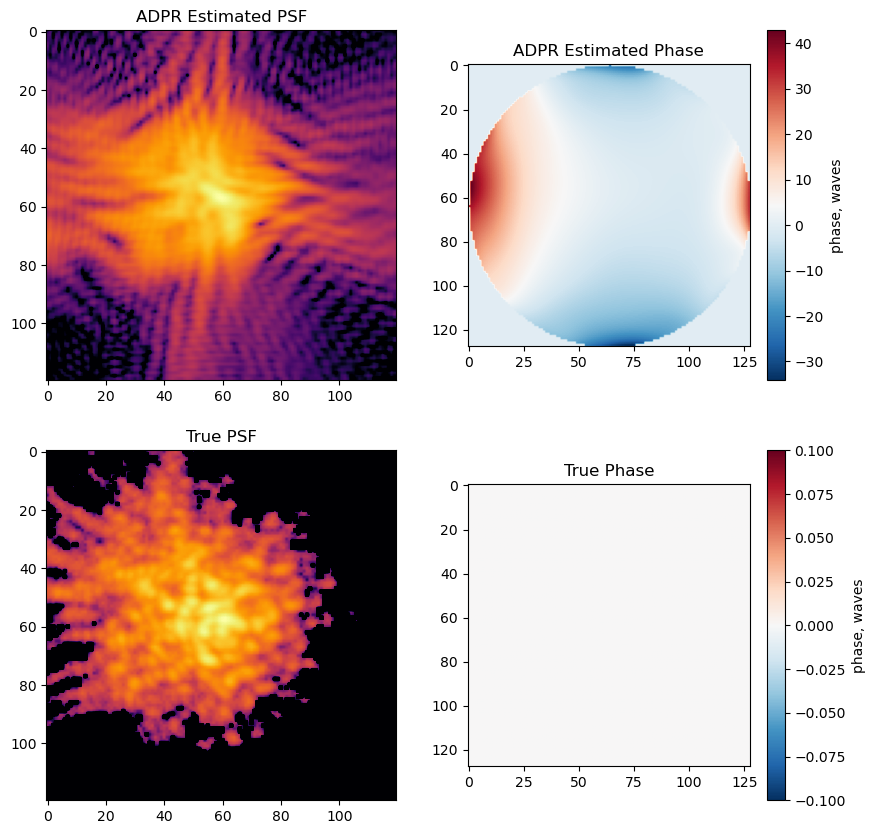

In [11]:
k = 2 * np.pi / wvl

psf_est = fdpr.optlist[0].I
psf_est /= psf_est.max()
psf_truth = fdpr.optlist[0].D
psf_truth /= psf_truth.max()

phase_est = fdpr.optlist[0].W #sum_of_2d_modes(basis_norm, x)
phase_truth = phs


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(psf_est), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(psf_truth), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

In [ ]:
fdpr.optlist[0].I.sum()

479.0400340323544

In [ ]:
fdpr.optlist[0].D.sum()

481.16006835659357

In [ ]:
fdpr.optlist[1].I.sum()

11864.722734329715